In [1]:
# БЛОК 0 – Setup, распаковка, проверки, сбор путей

import os
import random
import zipfile
import numpy as np
import pandas as pd

from pathlib import Path

# 1) Конфиг путей (как у тебя)
DATA_DIR = Path("/content/init_data")
WORK_DIR = Path("/content/covers_work")
TRAIN_DIR = WORK_DIR / "train"
TEST_DIR  = WORK_DIR / "test"
OUT_DIR   = WORK_DIR / "outputs"

TRAIN_ZIP = DATA_DIR / "train_images_covers.zip"
TEST_ZIP  = DATA_DIR / "test_images_covers.zip"
LABELS_CSV = DATA_DIR / "train_labels_covers.csv"
SAMPLE_CSV = DATA_DIR / "sample_submission_covers.csv"

WORK_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 2) Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def unzip_if_needed(zip_path: Path, dst_root: Path):
    if not zip_path.exists():
        raise FileNotFoundError(f"Не найден архив: {zip_path}")
    with zipfile.ZipFile(zip_path, "r") as z:
        names = [n for n in z.namelist() if not n.endswith("/")]
        # ожидаем внутри что-то вроде train/images/*.jpg или test/images/*.jpg
        # проверим по первому файлу
        first = names[0]
    # Если уже распаковано (проверяем наличие папки train/images или test/images)
    marker = dst_root / first.split("/")[0] / first.split("/")[1]
    if marker.exists():
        print(f"OK – похоже уже распаковано: {marker}")
        return

    print(f"Распаковка {zip_path.name} -> {dst_root}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(dst_root)
    print("Готово")

# 3) Распаковка
unzip_if_needed(TRAIN_ZIP, WORK_DIR)
unzip_if_needed(TEST_ZIP, WORK_DIR)

# 4) Загрузка CSV
labels = pd.read_csv(LABELS_CSV)
sample = pd.read_csv(SAMPLE_CSV)

# 5) Проверки формата
required_cols = {"image_id", "c", "s"}
if set(labels.columns) != required_cols:
    raise ValueError(f"train_labels_covers.csv должен иметь колонки {required_cols}, сейчас {labels.columns.tolist()}")

if list(sample.columns) != ["image_id", "c", "s"]:
    raise ValueError(f"sample_submission_covers.csv должен иметь колонки ['image_id','c','s'], сейчас {sample.columns.tolist()}")

if labels.shape[0] != 2500:
    print(f"Предупреждение: строк в labels = {labels.shape[0]} (ожидалось 2500)")

if sample.shape[0] != 700:
    print(f"Предупреждение: строк в sample = {sample.shape[0]} (ожидалось 700)")

# 6) Сбор путей к изображениям
train_img_dir = WORK_DIR / "train" / "images"
test_img_dir  = WORK_DIR / "test" / "images"

if not train_img_dir.exists():
    raise FileNotFoundError(f"Не найдена папка {train_img_dir}. Проверь структуру архива train_images_covers.zip")
if not test_img_dir.exists():
    raise FileNotFoundError(f"Не найдена папка {test_img_dir}. Проверь структуру архива test_images_covers.zip")

labels["path"] = labels["image_id"].apply(lambda x: str(train_img_dir / f"{x}.jpg"))
sample["path"] = sample["image_id"].apply(lambda x: str(test_img_dir / f"{x}.jpg"))

# 7) Контроль, что все файлы на месте
missing_train = (~labels["path"].map(lambda p: Path(p).exists())).sum()
missing_test  = (~sample["path"].map(lambda p: Path(p).exists())).sum()

print("ИТОГО")
print(f"train images dir: {train_img_dir}")
print(f"test  images dir: {test_img_dir}")
print(f"labels: {labels.shape}, sample: {sample.shape}")
print(f"missing train files: {missing_train}")
print(f"missing test  files: {missing_test}")

if missing_train > 0:
    bad = labels.loc[~labels["path"].map(lambda p: Path(p).exists()), ["image_id","path"]].head(20)
    print("Примеры отсутствующих train:")
    print(bad)

if missing_test > 0:
    bad = sample.loc[~sample["path"].map(lambda p: Path(p).exists()), ["image_id","path"]].head(20)
    print("Примеры отсутствующих test:")
    print(bad)

# 8) Быстрые численные sanity checks по таргетам
labels["bg"] = 1.0 - labels["c"] - labels["s"]
print("\nТАРГЕТЫ (train)")
print(labels[["c","s","bg"]].describe().T)

# строгая проверка ограничений
if (labels["c"].lt(0).any() or labels["s"].lt(0).any() or labels["bg"].lt(0).any()):
    raise ValueError("Обнаружены отрицательные доли (c/s/bg) – данные неконсистентны")

# 9) Сохраним подготовленные датафреймы, чтобы дальше не пересобирать
labels.to_csv(OUT_DIR / "train_index.csv", index=False)
sample.to_csv(OUT_DIR / "test_index.csv", index=False)
print(f"\nСохранено:\n- {OUT_DIR/'train_index.csv'}\n- {OUT_DIR/'test_index.csv'}")


Распаковка train_images_covers.zip -> /content/covers_work
Готово
Распаковка test_images_covers.zip -> /content/covers_work
Готово
ИТОГО
train images dir: /content/covers_work/train/images
test  images dir: /content/covers_work/test/images
labels: (2500, 4), sample: (700, 4)
missing train files: 0
missing test  files: 0

ТАРГЕТЫ (train)
     count      mean       std       min       25%       50%       75%  \
c   2500.0  0.369193  0.085189  0.167542  0.301304  0.376549  0.439244   
s   2500.0  0.039364  0.029539  0.000000  0.016487  0.034409  0.056648   
bg  2500.0  0.591442  0.083043  0.393631  0.524581  0.583175  0.652740   

         max  
c   0.540466  
s   0.176804  
bg  0.816452  

Сохранено:
- /content/covers_work/outputs/train_index.csv
- /content/covers_work/outputs/test_index.csv


train_df: (2500, 5) test_df: (700, 4)

describe c/s/bg
     count      mean       std       min       25%       50%       75%  \
c   2500.0  0.369193  0.085189  0.167542  0.301304  0.376549  0.439244   
s   2500.0  0.039364  0.029539  0.000000  0.016487  0.034409  0.056648   
bg  2500.0  0.591442  0.083043  0.393631  0.524581  0.583175  0.652740   

         max  
c   0.540466  
s   0.176804  
bg  0.816452  

correlation
           c         s        bg
c   1.000000 -0.245126 -0.938654
s  -0.245126  1.000000 -0.104251
bg -0.938654 -0.104251  1.000000


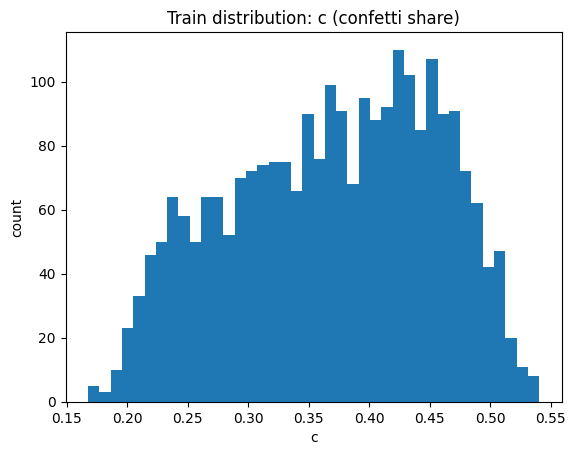

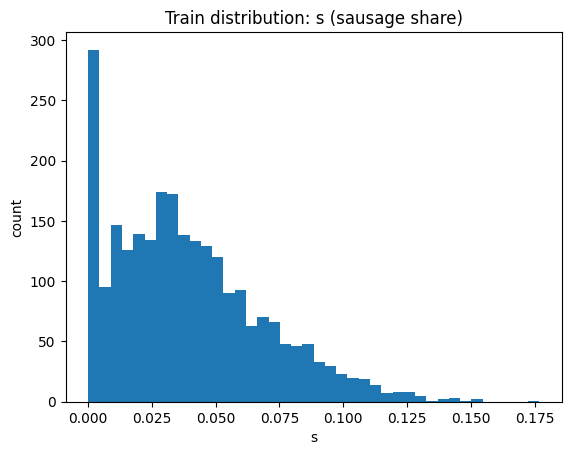

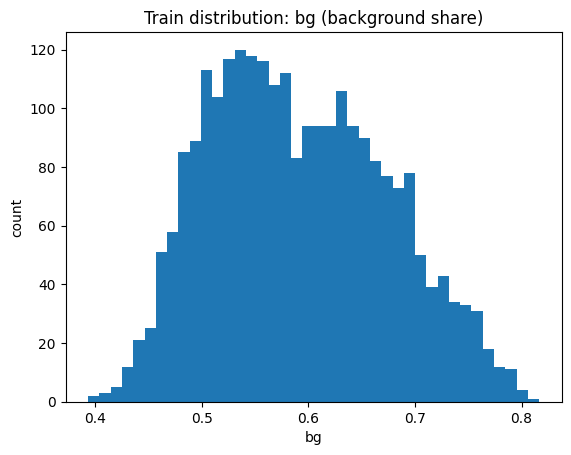


Top c


image_id         c         s        bg  \
1820  img_001821  0.540466  0.042084  0.417450   
2475  img_002476  0.539337  0.067032  0.393631   
2106  img_002107  0.538116  0.056641  0.405243   
121   img_000122  0.536133  0.010513  0.453354   
1569  img_001570  0.535126  0.030411  0.434463   
746   img_000747  0.534683  0.068542  0.396775   

                                                  path  
1820  /content/covers_work/train/images/img_001821.jpg  
2475  /content/covers_work/train/images/img_002476.jpg  
2106  /content/covers_work/train/images/img_002107.jpg  
121   /content/covers_work/train/images/img_000122.jpg  
1569  /content/covers_work/train/images/img_001570.jpg  
746   /content/covers_work/train/images/img_000747.jpg


Bottom c


image_id         c         s        bg  \
1230  img_001231  0.167542  0.016006  0.816452   
2061  img_002062  0.167816  0.044571  0.787613   
2157  img_002158  0.171402  0.043457  0.785141   
2318  img_002319  0.175568  0.045593  0.778839   
1488  img_001489  0.176285  0.038803  0.784912   
1087  img_001088  0.177597  0.096970  0.725433   

                                                  path  
1230  /content/covers_work/train/images/img_001231.jpg  
2061  /content/covers_work/train/images/img_002062.jpg  
2157  /content/covers_work/train/images/img_002158.jpg  
2318  /content/covers_work/train/images/img_002319.jpg  
1488  /content/covers_work/train/images/img_001489.jpg  
1087  /content/covers_work/train/images/img_001088.jpg


Top s


image_id         c         s        bg  \
588   img_000589  0.189484  0.176804  0.633712   
1810  img_001811  0.239883  0.153122  0.606995   
5     img_000006  0.233490  0.151306  0.615204   
1970  img_001971  0.237366  0.146805  0.615829   
71    img_000072  0.234726  0.143814  0.621460   
2077  img_002078  0.249878  0.143616  0.606506   

                                                  path  
588   /content/covers_work/train/images/img_000589.jpg  
1810  /content/covers_work/train/images/img_001811.jpg  
5     /content/covers_work/train/images/img_000006.jpg  
1970  /content/covers_work/train/images/img_001971.jpg  
71    /content/covers_work/train/images/img_000072.jpg  
2077  /content/covers_work/train/images/img_002078.jpg


Bottom s


image_id         c    s        bg  \
1951  img_001952  0.466385  0.0  0.533615   
626   img_000627  0.511185  0.0  0.488815   
640   img_000641  0.296432  0.0  0.703568   
1691  img_001692  0.485855  0.0  0.514145   
1633  img_001634  0.312454  0.0  0.687546   
1640  img_001641  0.398727  0.0  0.601273   

                                                  path  
1951  /content/covers_work/train/images/img_001952.jpg  
626   /content/covers_work/train/images/img_000627.jpg  
640   /content/covers_work/train/images/img_000641.jpg  
1691  /content/covers_work/train/images/img_001692.jpg  
1633  /content/covers_work/train/images/img_001634.jpg  
1640  /content/covers_work/train/images/img_001641.jpg

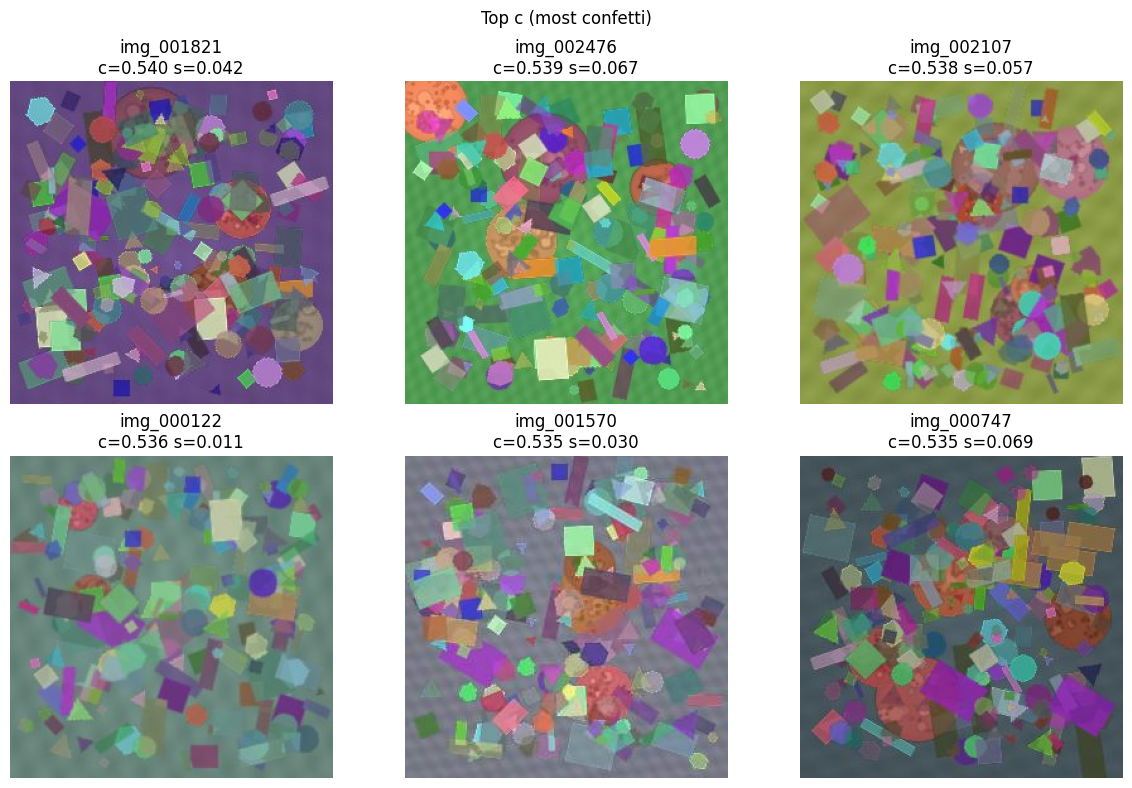

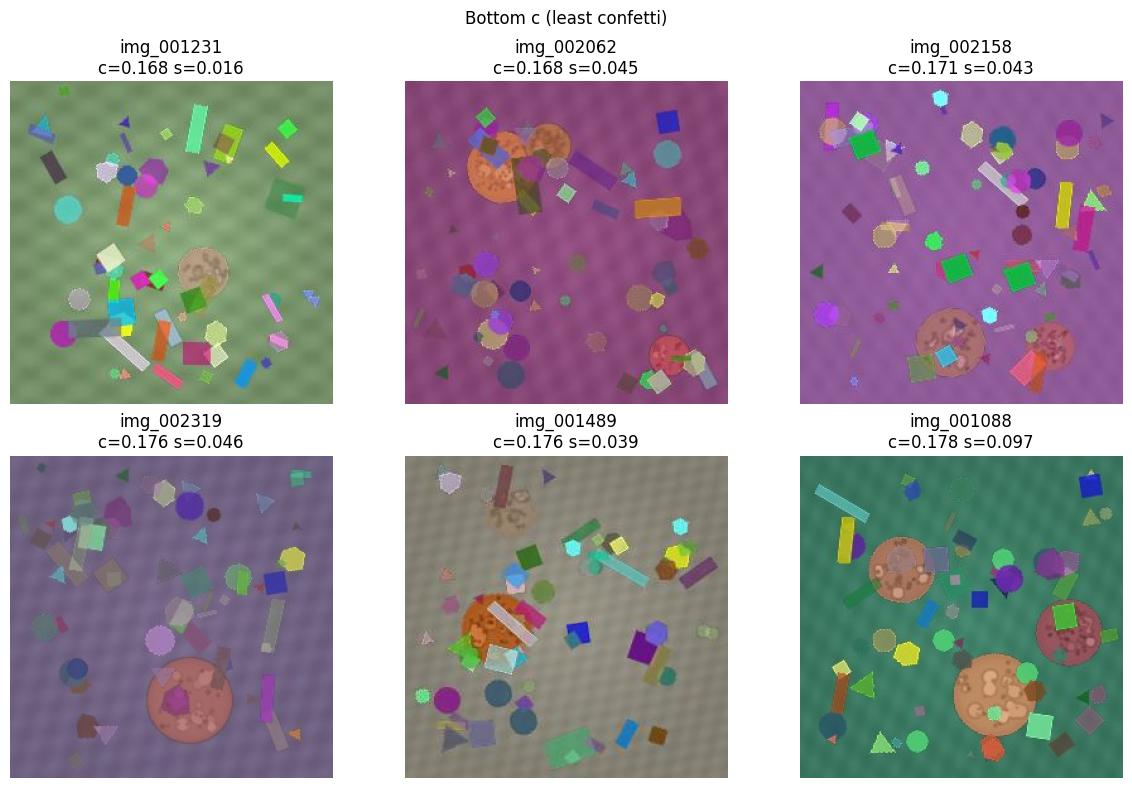

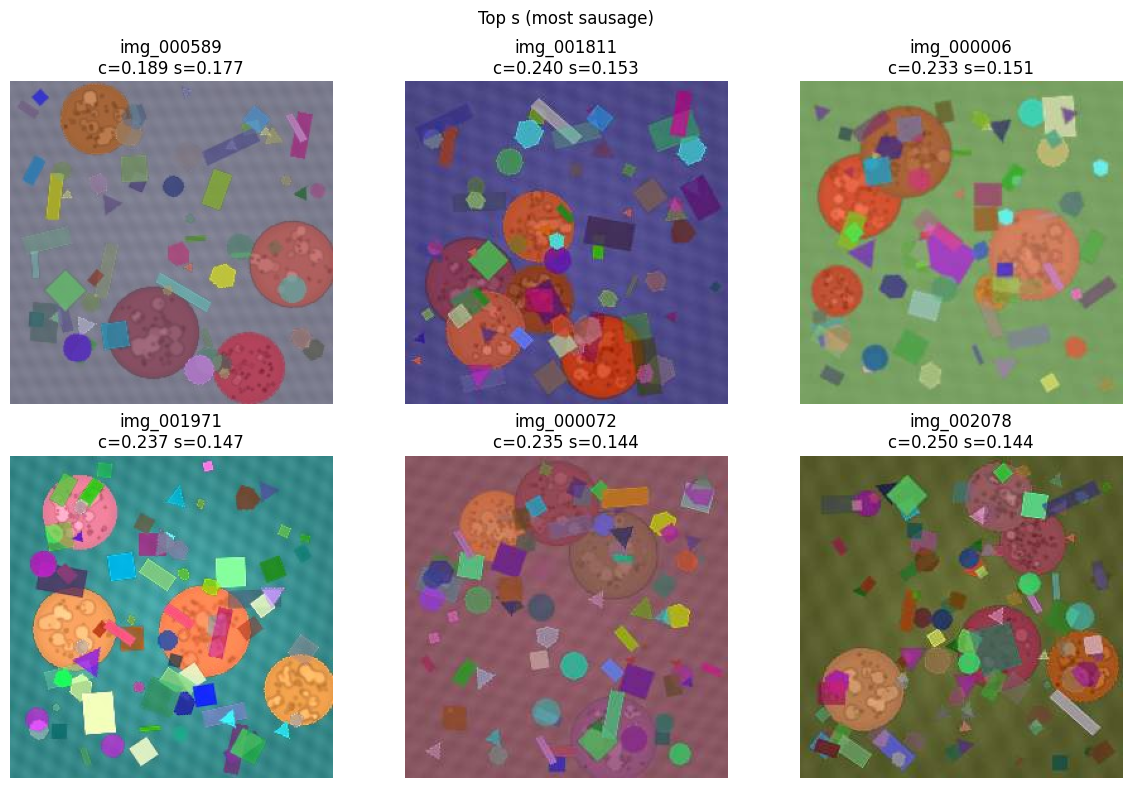

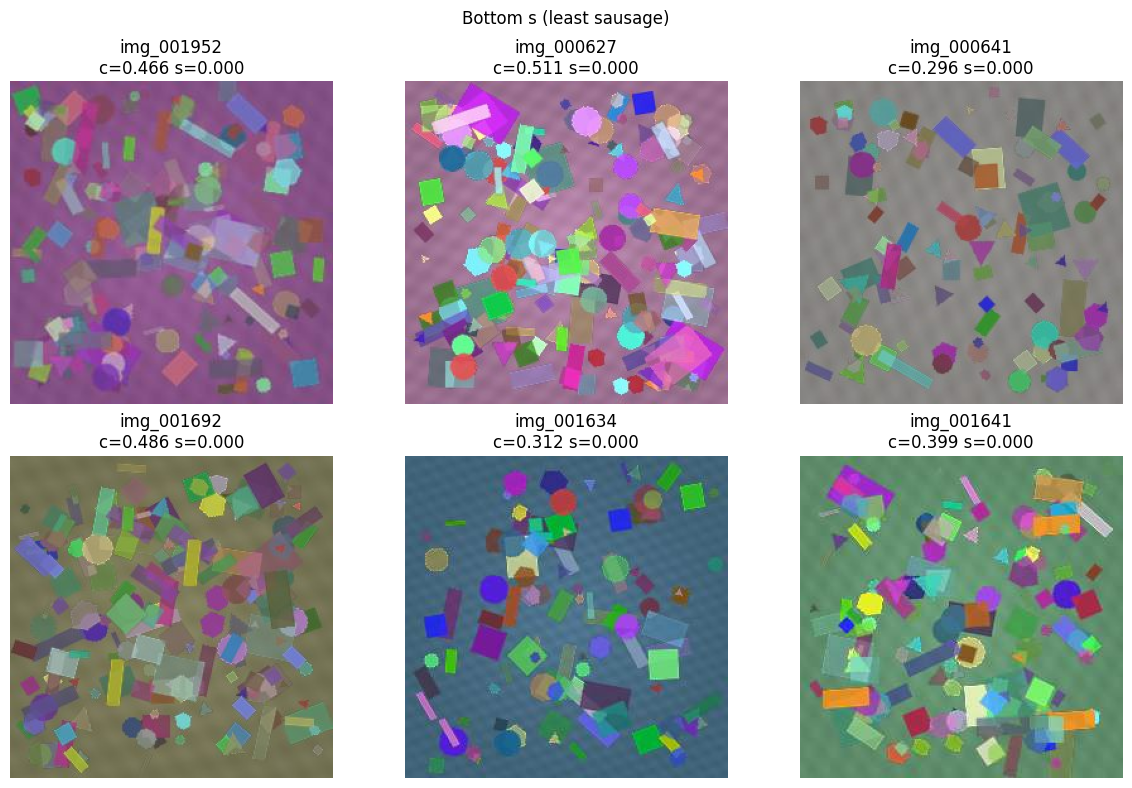


Baseline mean-predictor (train fit, for scale only)
c_mean=0.369193, s_mean=0.039364
MAE: c=0.072291, s=0.023607, avg=0.047949
RMSE: c=0.085172, s=0.029534, avg=0.057353

Violations (c+s>1): 0


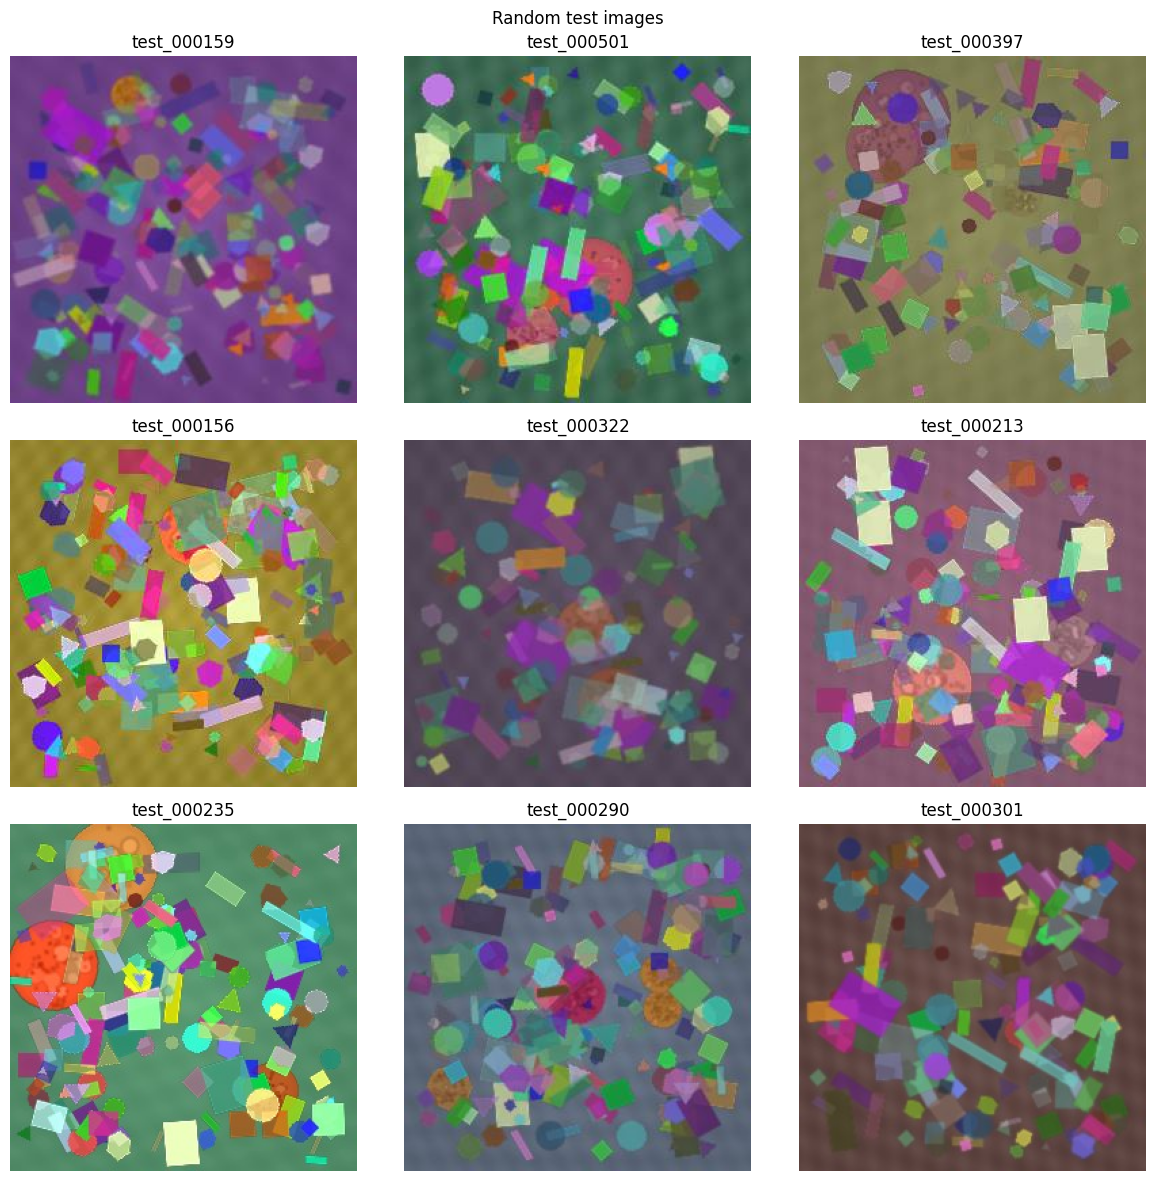

In [2]:
# БЛОК 1 – EDA, визуализации, baseline "средними", подбор крайних примеров

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

OUT_DIR = Path("/content/covers_work/outputs")
train_index_path = OUT_DIR / "train_index.csv"
test_index_path  = OUT_DIR / "test_index.csv"

train_df = pd.read_csv(train_index_path)
test_df  = pd.read_csv(test_index_path)

print("train_df:", train_df.shape, "test_df:", test_df.shape)

# 1) Базовые сводки и корреляции
print("\ndescribe c/s/bg")
print(train_df[["c","s","bg"]].describe().T)

print("\ncorrelation")
print(train_df[["c","s","bg"]].corr())

# 2) Гистограммы распределений
plt.figure()
plt.hist(train_df["c"].values, bins=40)
plt.title("Train distribution: c (confetti share)")
plt.xlabel("c")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(train_df["s"].values, bins=40)
plt.title("Train distribution: s (sausage share)")
plt.xlabel("s")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(train_df["bg"].values, bins=40)
plt.title("Train distribution: bg (background share)")
plt.xlabel("bg")
plt.ylabel("count")
plt.show()

# 3) Крайние кейсы по квантилям (самые большие/маленькие c и s)
def pick_examples(df, col, n=6, largest=True):
    if largest:
        return df.sort_values(col, ascending=False).head(n).copy()
    return df.sort_values(col, ascending=True).head(n).copy()

top_c = pick_examples(train_df, "c", n=6, largest=True)
bot_c = pick_examples(train_df, "c", n=6, largest=False)
top_s = pick_examples(train_df, "s", n=6, largest=True)
bot_s = pick_examples(train_df, "s", n=6, largest=False)

print("\nTop c")
display(top_c[["image_id","c","s","bg","path"]])

print("\nBottom c")
display(bot_c[["image_id","c","s","bg","path"]])

print("\nTop s")
display(top_s[["image_id","c","s","bg","path"]])

print("\nBottom s")
display(bot_s[["image_id","c","s","bg","path"]])

# 4) Визуальный просмотр выбранных кейсов
def show_grid(df, title, cols=3):
    rows = int(np.ceil(len(df) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))
    plt.suptitle(title)
    for i, (_, r) in enumerate(df.iterrows(), start=1):
        img = mpimg.imread(r["path"])
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f'{r["image_id"]}\nc={r["c"]:.3f} s={r["s"]:.3f}')
    plt.tight_layout()
    plt.show()

show_grid(top_c, "Top c (most confetti)")
show_grid(bot_c, "Bottom c (least confetti)")
show_grid(top_s, "Top s (most sausage)")
show_grid(bot_s, "Bottom s (least sausage)")

# 5) Baseline "угадывать среднее" – MAE по train (для понимания масштаба ошибки)
c_mean = float(train_df["c"].mean())
s_mean = float(train_df["s"].mean())

train_pred_c = np.full(len(train_df), c_mean, dtype=np.float32)
train_pred_s = np.full(len(train_df), s_mean, dtype=np.float32)

mae_c = np.mean(np.abs(train_df["c"].values - train_pred_c))
mae_s = np.mean(np.abs(train_df["s"].values - train_pred_s))
mae_avg = 0.5 * (mae_c + mae_s)

rmse_c = np.sqrt(np.mean((train_df["c"].values - train_pred_c) ** 2))
rmse_s = np.sqrt(np.mean((train_df["s"].values - train_pred_s) ** 2))
rmse_avg = 0.5 * (rmse_c + rmse_s)

print("\nBaseline mean-predictor (train fit, for scale only)")
print(f"c_mean={c_mean:.6f}, s_mean={s_mean:.6f}")
print(f"MAE: c={mae_c:.6f}, s={mae_s:.6f}, avg={mae_avg:.6f}")
print(f"RMSE: c={rmse_c:.6f}, s={rmse_s:.6f}, avg={rmse_avg:.6f}")

# 6) Проверка разумных границ таргетов
# Максимально допустимый c при данном s: c <= 1 - s (и наоборот). В train это уже выполнено.
viol = (train_df["c"] + train_df["s"] > 1.0 + 1e-9).sum()
print("\nViolations (c+s>1):", int(viol))

# 7) Быстрый sanity на test – просто покажем 9 случайных
test_sample = test_df.sample(9, random_state=42).copy()
plt.figure(figsize=(12, 12))
plt.suptitle("Random test images")
for i, (_, r) in enumerate(test_sample.iterrows(), start=1):
    img = mpimg.imread(r["path"])
    ax = plt.subplot(3, 3, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(r["image_id"])
plt.tight_layout()
plt.show()


In [3]:
# БЛОК 2 – Strong baseline (timm + 3 logits, soft labels, 5-fold CV, AMP, cosine)
# Цель: получить стабильный сильный CV и сохранить best weights по каждому фолду

!pip -q install timm albumentations opencv-python-headless

import os
import math
import time
import random
import numpy as np
import pandas as pd

from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold

# 1) Paths
OUT_DIR = Path("/content/covers_work/outputs")
train_df = pd.read_csv(OUT_DIR / "train_index.csv")
test_df  = pd.read_csv(OUT_DIR / "test_index.csv")

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 2) Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 3) Config baseline
CFG = {
    "model_name": "convnext_tiny",
    "img_size": 256,
    "batch_size": 64,
    "epochs": 18,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "num_folds": 5,
    "num_workers": 2,
    "grad_clip": 1.0,
    "warmup_epochs": 2,
}

# 4) Targets as 3-class distribution (confetti, sausage, background)
# y = [c, s, 1-c-s]
train_df["bg"] = 1.0 - train_df["c"] - train_df["s"]
y = train_df[["c", "s", "bg"]].values.astype(np.float32)

# 5) Augmentations (без кропов/erasing)
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        A.MotionBlur(blur_limit=(3, 7), p=1.0),
    ], p=0.25),
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 25.0), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
    ], p=0.25),
    A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# 6) Dataset
class CoversDataset(Dataset):
    def __init__(self, df, targets=None, tfms=None):
        self.df = df.reset_index(drop=True)
        self.targets = targets
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.tfms is not None:
            img = self.tfms(image=img)["image"]

        if self.targets is None:
            return img

        t = self.targets[idx]
        t = torch.tensor(t, dtype=torch.float32)
        return img, t

# 7) Model: timm backbone -> 3 logits
class TimmReg3(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=3,
        )

    def forward(self, x):
        return self.backbone(x)

# 8) Soft-label loss (KL between predicted probs and target distribution)
# Use KLDivLoss with log_softmax
class SoftKLLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl = nn.KLDivLoss(reduction="batchmean")

    def forward(self, logits, target_probs):
        logp = F.log_softmax(logits, dim=1)
        return self.kl(logp, target_probs)

loss_fn = SoftKLLoss()

# 9) Metric: MAE on c and s (from softmax probs)
@torch.no_grad()
def compute_mae_cs(probs, targets):
    # probs, targets: (B,3)
    c_pred = probs[:, 0]
    s_pred = probs[:, 1]
    c_true = targets[:, 0]
    s_true = targets[:, 1]
    mae_c = torch.mean(torch.abs(c_pred - c_true)).item()
    mae_s = torch.mean(torch.abs(s_pred - s_true)).item()
    return mae_c, mae_s, 0.5 * (mae_c + mae_s)

# 10) LR schedule: cosine with warmup (epoch-based)
def get_lr(epoch, base_lr, total_epochs, warmup_epochs):
    if epoch < warmup_epochs:
        return base_lr * float(epoch + 1) / float(max(1, warmup_epochs))
    t = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1.0 + math.cos(math.pi * t))

# 11) Train one fold
def run_fold(fold, tr_idx, va_idx):
    print(f"\nFold {fold+1}/{CFG['num_folds']} – train {len(tr_idx)} valid {len(va_idx)}")

    tr_ds = CoversDataset(train_df.iloc[tr_idx], targets=y[tr_idx], tfms=train_tfms)
    va_ds = CoversDataset(train_df.iloc[va_idx], targets=y[va_idx], tfms=valid_tfms)

    tr_loader = DataLoader(
        tr_ds, batch_size=CFG["batch_size"], shuffle=True,
        num_workers=CFG["num_workers"], pin_memory=True, drop_last=True
    )
    va_loader = DataLoader(
        va_ds, batch_size=CFG["batch_size"], shuffle=False,
        num_workers=CFG["num_workers"], pin_memory=True, drop_last=False
    )

    model = TimmReg3(CFG["model_name"]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    best_mae = 1e9
    best_path = CKPT_DIR / f"{CFG['model_name']}_sz{CFG['img_size']}_fold{fold}.pth"

    for epoch in range(CFG["epochs"]):
        lr = get_lr(epoch, CFG["lr"], CFG["epochs"], CFG["warmup_epochs"])
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        model.train()
        t0 = time.time()
        train_loss = 0.0
        n_train = 0

        for xb, tb in tr_loader:
            xb = xb.to(device, non_blocking=True)
            tb = tb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(xb)
                loss = loss_fn(logits, tb)

            scaler.scale(loss).backward()
            if CFG["grad_clip"] is not None:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
            scaler.step(optimizer)
            scaler.update()

            bs = xb.size(0)
            train_loss += loss.item() * bs
            n_train += bs

        train_loss /= max(1, n_train)

        model.eval()
        val_loss = 0.0
        n_val = 0
        mae_c_sum = 0.0
        mae_s_sum = 0.0
        mae_avg_sum = 0.0

        with torch.no_grad():
            for xb, tb in va_loader:
                xb = xb.to(device, non_blocking=True)
                tb = tb.to(device, non_blocking=True)

                logits = model(xb)
                loss = loss_fn(logits, tb)

                probs = F.softmax(logits, dim=1)
                mae_c, mae_s, mae_avg = compute_mae_cs(probs, tb)

                bs = xb.size(0)
                val_loss += loss.item() * bs
                mae_c_sum += mae_c * bs
                mae_s_sum += mae_s * bs
                mae_avg_sum += mae_avg * bs
                n_val += bs

        val_loss /= max(1, n_val)
        mae_c = mae_c_sum / max(1, n_val)
        mae_s = mae_s_sum / max(1, n_val)
        mae_avg = mae_avg_sum / max(1, n_val)

        dt = time.time() - t0
        print(
            f"epoch {epoch+1:02d}/{CFG['epochs']} – "
            f"lr {lr:.2e} – "
            f"train_loss {train_loss:.5f} – "
            f"val_loss {val_loss:.5f} – "
            f"MAE c {mae_c:.5f} s {mae_s:.5f} avg {mae_avg:.5f} – "
            f"time {dt:.1f}s"
        )

        if mae_avg < best_mae:
            best_mae = mae_avg
            torch.save(
                {
                    "model_name": CFG["model_name"],
                    "img_size": CFG["img_size"],
                    "state_dict": model.state_dict(),
                    "best_mae_avg": best_mae,
                    "epoch": epoch + 1,
                    "cfg": CFG,
                },
                best_path
            )
            print(f"saved best -> {best_path.name} (best_mae_avg={best_mae:.5f})")

    return float(best_mae), str(best_path)

# 12) KFold training
kf = KFold(n_splits=CFG["num_folds"], shuffle=True, random_state=SEED)

fold_results = []
for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df)):
    best_mae, best_path = run_fold(fold, tr_idx, va_idx)
    fold_results.append({"fold": fold, "best_mae_avg": best_mae, "ckpt": best_path})

res = pd.DataFrame(fold_results)
display(res)
print("\nCV mean best_mae_avg:", res["best_mae_avg"].mean())

res.to_csv(OUT_DIR / f"cv_results_{CFG['model_name']}_sz{CFG['img_size']}.csv", index=False)
print("saved:", OUT_DIR / f"cv_results_{CFG['model_name']}_sz{CFG['img_size']}.csv")


device: cuda

Fold 1/5 – train 2000 valid 500


/tmp/ipython-input-3368978087.py:77: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 25.0), p=1.0),
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/tmp/ipython-input-3368978087.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-3368978087.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


epoch 01/18 – lr 1.00e-04 – train_loss 0.50457 – val_loss 0.02647 – MAE c 0.06227 s 0.02566 avg 0.04397 – time 30.7s
saved best -> convnext_tiny_sz256_fold0.pth (best_mae_avg=0.04397)
epoch 02/18 – lr 2.00e-04 – train_loss 0.03602 – val_loss 0.01497 – MAE c 0.03124 s 0.02276 avg 0.02700 – time 14.3s
saved best -> convnext_tiny_sz256_fold0.pth (best_mae_avg=0.02700)
epoch 03/18 – lr 2.00e-04 – train_loss 0.01755 – val_loss 0.01303 – MAE c 0.02023 s 0.02308 avg 0.02166 – time 14.4s
saved best -> convnext_tiny_sz256_fold0.pth (best_mae_avg=0.02166)
epoch 04/18 – lr 1.98e-04 – train_loss 0.01575 – val_loss 0.01393 – MAE c 0.02283 s 0.02363 avg 0.02323 – time 14.1s
epoch 05/18 – lr 1.92e-04 – train_loss 0.01276 – val_loss 0.00705 – MAE c 0.02702 s 0.01419 avg 0.02060 – time 14.3s
saved best -> convnext_tiny_sz256_fold0.pth (best_mae_avg=0.02060)
epoch 06/18 – lr 1.83e-04 – train_loss 0.00662 – val_loss 0.00279 – MAE c 0.01657 s 0.00792 avg 0.01224 – time 14.5s
saved best -> convnext_tiny_sz

fold  best_mae_avg                                               ckpt
0     0      0.006234  /content/covers_work/outputs/checkpoints/convn...
1     1      0.005903  /content/covers_work/outputs/checkpoints/convn...
2     2      0.006290  /content/covers_work/outputs/checkpoints/convn...
3     3      0.006179  /content/covers_work/outputs/checkpoints/convn...
4     4      0.007631  /content/covers_work/outputs/checkpoints/convn...


CV mean best_mae_avg: 0.006447557660378515
saved: /content/covers_work/outputs/cv_results_convnext_tiny_sz256.csv


In [4]:
# БЛОК 3 – Усиление: EMA + MixUp + img_size=320 + аккуратные аугментации
# Выход: новые чекпойнты *_ema_mixup_sz320_foldK.pth и CV таблица

!pip -q install timm albumentations opencv-python-headless

import os
import math
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold

OUT_DIR = Path("/content/covers_work/outputs")
train_df = pd.read_csv(OUT_DIR / "train_index.csv")
test_df  = pd.read_csv(OUT_DIR / "test_index.csv")

CKPT_DIR = OUT_DIR / "checkpoints_v2"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

CFG = {
    "model_name": "convnext_tiny",
    "img_size": 320,
    "batch_size": 48,          # для T4 безопаснее при 320
    "epochs": 20,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "num_folds": 5,
    "num_workers": 2,
    "grad_clip": 1.0,
    "warmup_epochs": 2,
    "ema_decay": 0.999,
    "mixup_p": 0.8,
    "mixup_alpha": 0.4,
}

train_df["bg"] = 1.0 - train_df["c"] - train_df["s"]
y = train_df[["c", "s", "bg"]].values.astype(np.float32)

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        A.MotionBlur(blur_limit=(3, 7), p=1.0),
    ], p=0.25),
    A.OneOf([
        A.GaussNoise(variance_range=(5.0, 25.0), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
    ], p=0.25),
    A.ColorJitter(brightness=0.18, contrast=0.18, saturation=0.18, hue=0.06, p=0.6),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CoversDataset(Dataset):
    def __init__(self, df, targets=None, tfms=None):
        self.df = df.reset_index(drop=True)
        self.targets = targets
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.tfms is not None:
            img = self.tfms(image=img)["image"]
        if self.targets is None:
            return img
        t = torch.tensor(self.targets[idx], dtype=torch.float32)
        return img, t

class TimmReg3(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=3)
    def forward(self, x):
        return self.backbone(x)

class SoftKLLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl = nn.KLDivLoss(reduction="batchmean")
    def forward(self, logits, target_probs):
        logp = F.log_softmax(logits, dim=1)
        return self.kl(logp, target_probs)

loss_fn = SoftKLLoss()

# EMA helper
@torch.no_grad()
def ema_update(ema_model, model, decay):
    msd = model.state_dict()
    for k, v in ema_model.state_dict().items():
        if k in msd:
            v.copy_(v * decay + msd[k] * (1.0 - decay))

def get_lr(epoch, base_lr, total_epochs, warmup_epochs):
    if epoch < warmup_epochs:
        return base_lr * float(epoch + 1) / float(max(1, warmup_epochs))
    t = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1.0 + math.cos(math.pi * t))

def mixup_batch(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x2 = x[idx]
    y2 = y[idx]
    x_mix = lam * x + (1 - lam) * x2
    y_mix = lam * y + (1 - lam) * y2
    return x_mix, y_mix

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    abs_c_sum = 0.0
    abs_s_sum = 0.0
    n = 0
    total_loss = 0.0

    for xb, tb in loader:
        xb = xb.to(device, non_blocking=True)
        tb = tb.to(device, non_blocking=True)

        logits = model(xb)
        loss = loss_fn(logits, tb)

        probs = F.softmax(logits, dim=1)
        abs_c_sum += torch.abs(probs[:, 0] - tb[:, 0]).sum().item()
        abs_s_sum += torch.abs(probs[:, 1] - tb[:, 1]).sum().item()
        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    mae_c = abs_c_sum / max(1, n)
    mae_s = abs_s_sum / max(1, n)
    mae_avg = 0.5 * (mae_c + mae_s)
    total_loss = total_loss / max(1, n)
    return total_loss, mae_c, mae_s, mae_avg

def run_fold(fold, tr_idx, va_idx):
    print(f"\nFold {fold+1}/{CFG['num_folds']} – train {len(tr_idx)} valid {len(va_idx)}")

    tr_ds = CoversDataset(train_df.iloc[tr_idx], targets=y[tr_idx], tfms=train_tfms)
    va_ds = CoversDataset(train_df.iloc[va_idx], targets=y[va_idx], tfms=valid_tfms)

    tr_loader = DataLoader(tr_ds, batch_size=CFG["batch_size"], shuffle=True,
                           num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
    va_loader = DataLoader(va_ds, batch_size=CFG["batch_size"], shuffle=False,
                           num_workers=CFG["num_workers"], pin_memory=True, drop_last=False)

    model = TimmReg3(CFG["model_name"]).to(device)
    ema_model = TimmReg3(CFG["model_name"]).to(device)
    ema_model.load_state_dict(model.state_dict())
    for p in ema_model.parameters():
        p.requires_grad = False

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    best_mae = 1e9
    best_path = CKPT_DIR / f"{CFG['model_name']}_ema_mixup_sz{CFG['img_size']}_fold{fold}.pth"

    for epoch in range(CFG["epochs"]):
        lr = get_lr(epoch, CFG["lr"], CFG["epochs"], CFG["warmup_epochs"])
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        model.train()
        t0 = time.time()
        train_loss = 0.0
        n_train = 0

        for xb, tb in tr_loader:
            xb = xb.to(device, non_blocking=True)
            tb = tb.to(device, non_blocking=True)

            if random.random() < CFG["mixup_p"]:
                xb, tb = mixup_batch(xb, tb, alpha=CFG["mixup_alpha"])

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
                logits = model(xb)
                loss = loss_fn(logits, tb)

            scaler.scale(loss).backward()
            if CFG["grad_clip"] is not None:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
            scaler.step(optimizer)
            scaler.update()

            ema_update(ema_model, model, CFG["ema_decay"])

            bs = xb.size(0)
            train_loss += loss.item() * bs
            n_train += bs

        train_loss /= max(1, n_train)

        val_loss, mae_c, mae_s, mae_avg = eval_loader(ema_model, va_loader)
        dt = time.time() - t0

        print(
            f"epoch {epoch+1:02d}/{CFG['epochs']} – "
            f"lr {lr:.2e} – train_loss {train_loss:.5f} – "
            f"val_loss {val_loss:.5f} – "
            f"MAE c {mae_c:.5f} s {mae_s:.5f} avg {mae_avg:.5f} – "
            f"time {dt:.1f}s"
        )

        if mae_avg < best_mae:
            best_mae = mae_avg
            torch.save(
                {
                    "model_name": CFG["model_name"],
                    "img_size": CFG["img_size"],
                    "state_dict": ema_model.state_dict(),
                    "best_mae_avg": best_mae,
                    "epoch": epoch + 1,
                    "cfg": CFG,
                },
                best_path
            )
            print(f"saved best -> {best_path.name} (best_mae_avg={best_mae:.5f})")

    return float(best_mae), str(best_path)

kf = KFold(n_splits=CFG["num_folds"], shuffle=True, random_state=SEED)

fold_results = []
for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df)):
    best_mae, best_path = run_fold(fold, tr_idx, va_idx)
    fold_results.append({"fold": fold, "best_mae_avg": best_mae, "ckpt": best_path})

res = pd.DataFrame(fold_results)
display(res)
print("\nCV mean best_mae_avg:", res["best_mae_avg"].mean())

csv_path = OUT_DIR / f"cv_results_{CFG['model_name']}_ema_mixup_sz{CFG['img_size']}.csv"
res.to_csv(csv_path, index=False)
print("saved:", csv_path)


device: cuda

Fold 1/5 – train 2000 valid 500


/tmp/ipython-input-1317621319.py:73: UserWarning: Argument(s) 'variance_range' are not valid for transform GaussNoise
  A.GaussNoise(variance_range=(5.0, 25.0), p=1.0),


epoch 01/20 – lr 1.00e-04 – train_loss 0.18274 – val_loss 0.21941 – MAE c 0.15192 s 0.20039 avg 0.17616 – time 38.5s
saved best -> convnext_tiny_ema_mixup_sz320_fold0.pth (best_mae_avg=0.17616)
epoch 02/20 – lr 2.00e-04 – train_loss 0.02508 – val_loss 0.10274 – MAE c 0.11870 s 0.10089 avg 0.10979 – time 23.1s
saved best -> convnext_tiny_ema_mixup_sz320_fold0.pth (best_mae_avg=0.10979)
epoch 03/20 – lr 2.00e-04 – train_loss 0.01856 – val_loss 0.08230 – MAE c 0.08660 s 0.09435 avg 0.09048 – time 23.0s
saved best -> convnext_tiny_ema_mixup_sz320_fold0.pth (best_mae_avg=0.09048)
epoch 04/20 – lr 1.98e-04 – train_loss 0.01316 – val_loss 0.07172 – MAE c 0.07033 s 0.08042 avg 0.07538 – time 23.3s
saved best -> convnext_tiny_ema_mixup_sz320_fold0.pth (best_mae_avg=0.07538)
epoch 05/20 – lr 1.94e-04 – train_loss 0.00881 – val_loss 0.06274 – MAE c 0.07125 s 0.06247 avg 0.06686 – time 23.5s
saved best -> convnext_tiny_ema_mixup_sz320_fold0.pth (best_mae_avg=0.06686)
epoch 06/20 – lr 1.87e-04 – tr

fold  best_mae_avg                                               ckpt
0     0      0.026127  /content/covers_work/outputs/checkpoints_v2/co...
1     1      0.021435  /content/covers_work/outputs/checkpoints_v2/co...
2     2      0.015826  /content/covers_work/outputs/checkpoints_v2/co...
3     3      0.022030  /content/covers_work/outputs/checkpoints_v2/co...
4     4      0.022022  /content/covers_work/outputs/checkpoints_v2/co...


CV mean best_mae_avg: 0.021487892344594
saved: /content/covers_work/outputs/cv_results_convnext_tiny_ema_mixup_sz320.csv


In [5]:
# БЛОК 4 – Inference: ensemble (5 folds) + TTA, export submission.csv

!pip -q install timm albumentations opencv-python-headless

import math
import numpy as np
import pandas as pd
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------------------------
# Paths
# -------------------------
OUT_DIR = Path("/content/covers_work/outputs")
test_df  = pd.read_csv(OUT_DIR / "test_index.csv")
sample   = pd.read_csv(Path("/content/init_data") / "sample_submission_covers.csv")

CKPT_DIR = OUT_DIR / "checkpoints"  # это папка Блока 2
MODEL_NAME = "convnext_tiny"
IMG_SIZE = 256

ckpts = [
    CKPT_DIR / f"{MODEL_NAME}_sz{IMG_SIZE}_fold0.pth",
    CKPT_DIR / f"{MODEL_NAME}_sz{IMG_SIZE}_fold1.pth",
    CKPT_DIR / f"{MODEL_NAME}_sz{IMG_SIZE}_fold2.pth",
    CKPT_DIR / f"{MODEL_NAME}_sz{IMG_SIZE}_fold3.pth",
    CKPT_DIR / f"{MODEL_NAME}_sz{IMG_SIZE}_fold4.pth",
]

for p in ckpts:
    if not p.exists():
        raise FileNotFoundError(f"Не найден чекпойнт: {p}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("num test:", len(test_df))

# -------------------------
# Transforms
# -------------------------
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

test_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# -------------------------
# Dataset
# -------------------------
class CoversTestDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.tfms is not None:
            img = self.tfms(image=img)["image"]
        return img

# -------------------------
# Model
# -------------------------
class TimmReg3(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=False, num_classes=3)

    def forward(self, x):
        return self.backbone(x)

def load_model(ckpt_path: Path):
    model = TimmReg3(MODEL_NAME).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.eval()
    return model

models = [load_model(p) for p in ckpts]
print("loaded models:", len(models))

# -------------------------
# TTA helpers
# -------------------------
def tta_stack(x):
    # x: (B,C,H,W)
    xs = []
    xs.append(x)  # identity
    xs.append(torch.flip(x, dims=[3]))       # hflip
    xs.append(torch.flip(x, dims=[2]))       # vflip
    xs.append(torch.rot90(x, k=1, dims=[2,3]))  # rot90
    return xs

@torch.no_grad()
def predict_probs_ensemble_tta(loader):
    all_probs = []

    for xb in loader:
        xb = xb.to(device, non_blocking=True)

        # accumulate probs across models and TTA
        probs_acc = 0.0
        denom = 0

        x_ttas = tta_stack(xb)
        for x_aug in x_ttas:
            for m in models:
                logits = m(x_aug)
                probs = F.softmax(logits, dim=1)  # (B,3)
                probs_acc += probs
                denom += 1

        probs_acc = probs_acc / float(denom)
        all_probs.append(probs_acc.detach().cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()  # (N,3)
    return all_probs

# -------------------------
# Run inference
# -------------------------
ds = CoversTestDataset(test_df, tfms=test_tfms)
loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

probs = predict_probs_ensemble_tta(loader)  # columns: [c, s, bg]
c_pred = probs[:, 0].astype(np.float64)
s_pred = probs[:, 1].astype(np.float64)

# -------------------------
# Safety postprocess for constraints
# c>=0, s>=0, c+s<=1
# -------------------------
c_pred = np.clip(c_pred, 0.0, 1.0)
s_pred = np.clip(s_pred, 0.0, 1.0)

sum_cs = c_pred + s_pred
mask = sum_cs > 1.0
if mask.any():
    # простая проекция на симплекс: масштабируем c и s, сохранив пропорцию
    c_pred[mask] = c_pred[mask] / sum_cs[mask]
    s_pred[mask] = s_pred[mask] / sum_cs[mask]

# -------------------------
# Build submission строго по sample
# -------------------------
sub = sample.copy()
sub = sub.sort_values("image_id").reset_index(drop=True)

pred_df = pd.DataFrame({
    "image_id": test_df["image_id"].values,
    "c": c_pred,
    "s": s_pred,
}).sort_values("image_id").reset_index(drop=True)

# гарантируем совпадение порядка
if not (sub["image_id"].values == pred_df["image_id"].values).all():
    # если вдруг sample имеет иной порядок – делаем merge по ключу
    sub = sub.drop(columns=["c","s"]).merge(pred_df, on="image_id", how="left")
else:
    sub["c"] = pred_df["c"].values
    sub["s"] = pred_df["s"].values

out_path = OUT_DIR / "submission.csv"
sub.to_csv(out_path, index=False)
print("saved:", out_path)
print(sub.head())
print("c range:", float(sub["c"].min()), float(sub["c"].max()))
print("s range:", float(sub["s"].min()), float(sub["s"].max()))
print("violations c+s>1:", int((sub["c"] + sub["s"] > 1.0 + 1e-12).sum()))


device: cuda
num test: 700
loaded models: 5
saved: /content/covers_work/outputs/submission.csv
      image_id         c         s
0  test_000001  0.422249  0.021796
1  test_000002  0.462305  0.000555
2  test_000003  0.425153  0.031642
3  test_000004  0.222526  0.032728
4  test_000005  0.367814  0.013608
c range: 0.1980777084827423 0.5240125060081482
s range: 0.00020896639034617692 0.1641416847705841
violations c+s>1: 0


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

OUT_DIR = Path("/content/covers_work/outputs")
train_df = pd.read_csv(OUT_DIR / "train_index.csv")

# targets
train_df["bg"] = 1.0 - train_df["c"] - train_df["s"]

# 2D-binning for stratification
# число бинов подбирается так, чтобы в каждом было достаточно примеров
n_bins_c = 10
n_bins_s = 8

c_bins = pd.qcut(train_df["c"], q=n_bins_c, labels=False, duplicates="drop")
# s имеет много малых значений – qcut тоже норм, но можно усилить log-scale биннинг
s_bins = pd.qcut(train_df["s"], q=n_bins_s, labels=False, duplicates="drop")

strata = (c_bins.astype(str) + "_" + s_bins.astype(str)).values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_ids = np.zeros(len(train_df), dtype=np.int64)

for fold, (_, va_idx) in enumerate(skf.split(train_df, strata)):
    fold_ids[va_idx] = fold

train_df["fold"] = fold_ids
train_df[["image_id","c","s","bg","path","fold"]].to_csv(OUT_DIR / "train_index_folds.csv", index=False)

print(train_df["fold"].value_counts().sort_index())
print("saved:", OUT_DIR / "train_index_folds.csv")


fold
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64
saved: /content/covers_work/outputs/train_index_folds.csv


In [7]:
!pip -q install timm albumentations opencv-python-headless

import math
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

OUT_DIR = Path("/content/covers_work/outputs")
df = pd.read_csv(OUT_DIR / "train_index_folds.csv")

CKPT_DIR = OUT_DIR / "checkpoints_ideal"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

CFG = {
    "model_name": "convnext_small",  # попробуй также "efficientnetv2_s"
    "img_size": 384,                # если OOM – 320
    "batch_size": 24,               # под 384 обычно 16-32
    "grad_accum": 2,                # эффективный batch = batch_size * grad_accum
    "epochs": 22,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "num_folds": 5,
    "num_workers": 2,
    "grad_clip": 1.0,
    "warmup_epochs": 2,
    "use_ema": True,
    "ema_decay": 0.999,
    "lambda_mae": 0.5,              # вклад MAE(cs) в loss
}

# targets
y = df[["c","s","bg"]].values.astype(np.float32)

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

# строго фотометрия, без кропов/erasing, минимум геометрии
train_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        A.MotionBlur(blur_limit=(3, 7), p=1.0),
    ], p=0.20),
    A.OneOf([
        A.GaussNoise(std_range=(0.02, 0.08), per_channel=True, p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
    ], p=0.20),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
        A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=12, val_shift_limit=10, p=1.0),
        A.RGBShift(r_shift_limit=8, g_shift_limit=8, b_shift_limit=8, p=1.0),
    ], p=0.55),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CoversDataset(Dataset):
    def __init__(self, df_, y_, tfms=None):
        self.df = df_.reset_index(drop=True)
        self.y = y_
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.tfms is not None:
            img = self.tfms(image=img)["image"]
        t = torch.tensor(self.y[idx], dtype=torch.float32)
        return img, t

class TimmReg3(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=3)

    def forward(self, x):
        return self.backbone(x)

class KLPlusMAE(nn.Module):
    def __init__(self, lambda_mae=0.5):
        super().__init__()
        self.kl = nn.KLDivLoss(reduction="batchmean")
        self.lambda_mae = lambda_mae

    def forward(self, logits, target_probs):
        logp = F.log_softmax(logits, dim=1)
        kl = self.kl(logp, target_probs)
        probs = F.softmax(logits, dim=1)
        mae_cs = 0.5 * (torch.mean(torch.abs(probs[:,0] - target_probs[:,0])) +
                        torch.mean(torch.abs(probs[:,1] - target_probs[:,1])))
        return kl + self.lambda_mae * mae_cs

loss_fn = KLPlusMAE(lambda_mae=CFG["lambda_mae"])

@torch.no_grad()
def ema_update(ema_model, model, decay):
    msd = model.state_dict()
    for k, v in ema_model.state_dict().items():
        if k in msd:
            v.copy_(v * decay + msd[k] * (1.0 - decay))

def get_lr(epoch, base_lr, total_epochs, warmup_epochs):
    if epoch < warmup_epochs:
        return base_lr * float(epoch + 1) / float(max(1, warmup_epochs))
    t = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1.0 + math.cos(math.pi * t))

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    abs_c_sum = 0.0
    abs_s_sum = 0.0
    n = 0
    for xb, tb in loader:
        xb = xb.to(device, non_blocking=True)
        tb = tb.to(device, non_blocking=True)
        logits = model(xb)
        probs = F.softmax(logits, dim=1)
        abs_c_sum += torch.abs(probs[:,0] - tb[:,0]).sum().item()
        abs_s_sum += torch.abs(probs[:,1] - tb[:,1]).sum().item()
        n += xb.size(0)
    mae_c = abs_c_sum / max(1, n)
    mae_s = abs_s_sum / max(1, n)
    mae_avg = 0.5 * (mae_c + mae_s)
    return mae_c, mae_s, mae_avg

def run_fold(fold):
    tr_df = df[df["fold"] != fold].reset_index(drop=True)
    va_df = df[df["fold"] == fold].reset_index(drop=True)

    tr_idx = tr_df.index.values
    va_idx = va_df.index.values

    y_tr = tr_df[["c","s","bg"]].values.astype(np.float32)
    y_va = va_df[["c","s","bg"]].values.astype(np.float32)

    tr_ds = CoversDataset(tr_df, y_tr, tfms=train_tfms)
    va_ds = CoversDataset(va_df, y_va, tfms=valid_tfms)

    tr_loader = DataLoader(
        tr_ds, batch_size=CFG["batch_size"], shuffle=True,
        num_workers=CFG["num_workers"], pin_memory=True, drop_last=True
    )
    va_loader = DataLoader(
        va_ds, batch_size=CFG["batch_size"], shuffle=False,
        num_workers=CFG["num_workers"], pin_memory=True, drop_last=False
    )

    model = TimmReg3(CFG["model_name"]).to(device)

    if CFG["use_ema"]:
        ema_model = TimmReg3(CFG["model_name"]).to(device)
        ema_model.load_state_dict(model.state_dict())
        for p in ema_model.parameters():
            p.requires_grad = False
    else:
        ema_model = None

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    best_mae = 1e9
    best_path = CKPT_DIR / f"{CFG['model_name']}_sz{CFG['img_size']}_fold{fold}.pth"

    for epoch in range(CFG["epochs"]):
        lr = get_lr(epoch, CFG["lr"], CFG["epochs"], CFG["warmup_epochs"])
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        model.train()
        t0 = time.time()

        optimizer.zero_grad(set_to_none=True)
        running = 0.0
        steps = 0

        for step, (xb, tb) in enumerate(tr_loader, start=1):
            xb = xb.to(device, non_blocking=True)
            tb = tb.to(device, non_blocking=True)

            with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
                logits = model(xb)
                loss = loss_fn(logits, tb)
                loss = loss / CFG["grad_accum"]

            scaler.scale(loss).backward()

            if step % CFG["grad_accum"] == 0:
                if CFG["grad_clip"] is not None:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                if CFG["use_ema"]:
                    ema_update(ema_model, model, CFG["ema_decay"])

            running += loss.item()
            steps += 1

        # eval on EMA if enabled
        eval_model = ema_model if CFG["use_ema"] else model
        mae_c, mae_s, mae_avg = eval_loader(eval_model, va_loader)
        dt = time.time() - t0

        print(
            f"fold {fold} epoch {epoch+1:02d}/{CFG['epochs']} - "
            f"lr {lr:.2e} - train_loss {running/max(1,steps):.6f} - "
            f"MAE c {mae_c:.6f} s {mae_s:.6f} avg {mae_avg:.6f} - "
            f"time {dt:.1f}s"
        )

        if mae_avg < best_mae:
            best_mae = mae_avg
            torch.save(
                {
                    "model_name": CFG["model_name"],
                    "img_size": CFG["img_size"],
                    "state_dict": eval_model.state_dict(),
                    "best_mae_avg": float(best_mae),
                    "epoch": epoch + 1,
                    "cfg": CFG,
                },
                best_path
            )
            print("saved best ->", best_path.name, "best_mae_avg=", float(best_mae))

    return float(best_mae), str(best_path)

fold_results = []
for fold in range(CFG["num_folds"]):
    best_mae, ckpt = run_fold(fold)
    fold_results.append({"fold": fold, "best_mae_avg": best_mae, "ckpt": ckpt})

res = pd.DataFrame(fold_results)
print(res)
print("CV mean:", res["best_mae_avg"].mean())

csv_path = OUT_DIR / f"cv_results_ideal_{CFG['model_name']}_sz{CFG['img_size']}.csv"
res.to_csv(csv_path, index=False)
print("saved:", csv_path)


device: cuda


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

fold 0 epoch 01/22 - lr 1.00e-04 - train_loss 0.109724 - MAE c 0.149914 s 0.034820 avg 0.092367 - time 70.1s
saved best -> convnext_small_sz384_fold0.pth best_mae_avg= 0.09236707341670991
fold 0 epoch 02/22 - lr 2.00e-04 - train_loss 0.024149 - MAE c 0.108302 s 0.061505 avg 0.084904 - time 53.4s
saved best -> convnext_small_sz384_fold0.pth best_mae_avg= 0.08490356802940369
fold 0 epoch 03/22 - lr 2.00e-04 - train_loss 0.027450 - MAE c 0.068820 s 0.107433 avg 0.088127 - time 53.1s
fold 0 epoch 04/22 - lr 1.99e-04 - train_loss 0.011383 - MAE c 0.060642 s 0.093997 avg 0.077319 - time 53.3s
saved best -> convnext_small_sz384_fold0.pth best_mae_avg= 0.07731937122344971
fold 0 epoch 05/22 - lr 1.95e-04 - train_loss 0.008067 - MAE c 0.083956 s 0.074300 avg 0.079128 - time 53.4s
fold 0 epoch 06/22 - lr 1.89e-04 - train_loss 0.005395 - MAE c 0.107229 s 0.055391 avg 0.081310 - time 53.1s
fold 0 epoch 07/22 - lr 1.81e-04 - train_loss 0.003454 - MAE c 0.118788 s 0.039398 avg 0.079093 - time 53.4s


In [8]:
!pip -q install timm albumentations opencv-python-headless

import numpy as np
import pandas as pd
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

OUT_DIR = Path("/content/covers_work/outputs")
test_df = pd.read_csv(OUT_DIR / "test_index.csv")
sample = pd.read_csv(Path("/content/init_data") / "sample_submission_covers.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "test:", len(test_df))

# список моделей на ансамбль
# сюда добавляешь разные папки и разные модели
ENSEMBLE = [
    # пример: результаты из checkpoints (Block 2)
    {
        "model_name": "convnext_tiny",
        "img_size": 256,
        "ckpts": [
            OUT_DIR / "checkpoints" / "convnext_tiny_sz256_fold0.pth",
            OUT_DIR / "checkpoints" / "convnext_tiny_sz256_fold1.pth",
            OUT_DIR / "checkpoints" / "convnext_tiny_sz256_fold2.pth",
            OUT_DIR / "checkpoints" / "convnext_tiny_sz256_fold3.pth",
            OUT_DIR / "checkpoints" / "convnext_tiny_sz256_fold4.pth",
        ],
        "weight": 1.0,
    },
    # пример: идеальные чекпойнты (Block 3.1)
    # {
    #     "model_name": "convnext_small",
    #     "img_size": 384,
    #     "ckpts": [
    #         OUT_DIR / "checkpoints_ideal" / "convnext_small_sz384_fold0.pth",
    #         OUT_DIR / "checkpoints_ideal" / "convnext_small_sz384_fold1.pth",
    #         OUT_DIR / "checkpoints_ideal" / "convnext_small_sz384_fold2.pth",
    #         OUT_DIR / "checkpoints_ideal" / "convnext_small_sz384_fold3.pth",
    #         OUT_DIR / "checkpoints_ideal" / "convnext_small_sz384_fold4.pth",
    #     ],
    #     "weight": 1.2,
    # },
]

for g in ENSEMBLE:
    for p in g["ckpts"]:
        if not p.exists():
            raise FileNotFoundError(f"missing ckpt: {p}")

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

class CoversTestDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.tfms(image=img)["image"]
        return img

class TimmReg3(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=False, num_classes=3)

    def forward(self, x):
        return self.backbone(x)

def load_model(model_name: str, ckpt_path: Path):
    model = TimmReg3(model_name).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.eval()
    return model

def tta_8(x):
    # x: (B,C,H,W)
    xs = []
    xs.append(x)
    xs.append(torch.flip(x, dims=[3]))                  # hflip
    xs.append(torch.flip(x, dims=[2]))                  # vflip
    xs.append(torch.rot90(x, k=1, dims=[2,3]))          # 90
    xs.append(torch.rot90(x, k=2, dims=[2,3]))          # 180
    xs.append(torch.rot90(x, k=3, dims=[2,3]))          # 270
    xs.append(torch.flip(torch.rot90(x, 1, [2,3]), [3]))# rot90 + hflip
    xs.append(torch.flip(torch.rot90(x, 1, [2,3]), [2]))# rot90 + vflip
    return xs

def project_simplex(v):
    # v: (N,3) numpy, projection to simplex {x>=0, sum=1}
    # algorithm: Wang-Carreira-Perpinan
    v_sorted = np.sort(v, axis=1)[:, ::-1]
    cssv = np.cumsum(v_sorted, axis=1) - 1
    ind = np.arange(1, v.shape[1] + 1)
    cond = v_sorted - cssv / ind > 0
    rho = cond.sum(axis=1) - 1
    theta = cssv[np.arange(v.shape[0]), rho] / (rho + 1)
    w = np.maximum(v - theta[:, None], 0)
    return w

@torch.no_grad()
def predict_ensemble():
    # для каждой группы моделей свой resize
    probs_sum = None
    w_sum = 0.0

    for group in ENSEMBLE:
        tfms = A.Compose([
            A.Resize(group["img_size"], group["img_size"]),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
        ds = CoversTestDataset(test_df, tfms=tfms)
        loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

        models = [load_model(group["model_name"], p) for p in group["ckpts"]]
        group_weight = float(group.get("weight", 1.0))

        all_probs = []
        for xb in loader:
            xb = xb.to(device, non_blocking=True)

            acc = 0.0
            denom = 0

            for x_aug in tta_8(xb):
                for m in models:
                    logits = m(x_aug)
                    acc += F.softmax(logits, dim=1)
                    denom += 1

            acc = acc / float(denom)
            all_probs.append(acc.detach().cpu())

        group_probs = torch.cat(all_probs, dim=0).numpy()  # (N,3)
        if probs_sum is None:
            probs_sum = group_weight * group_probs
        else:
            probs_sum += group_weight * group_probs
        w_sum += group_weight

    probs = probs_sum / max(1e-12, w_sum)

    # проекция на симплекс для строгих ограничений
    probs = project_simplex(probs)

    return probs

probs = predict_ensemble()
c_pred = probs[:, 0].astype(np.float64)
s_pred = probs[:, 1].astype(np.float64)

sub = sample.drop(columns=["c","s"]).merge(
    pd.DataFrame({"image_id": test_df["image_id"].values, "c": c_pred, "s": s_pred}),
    on="image_id", how="left"
)

out_path = OUT_DIR / "submission_ideal.csv"
sub.to_csv(out_path, index=False)

print("saved:", out_path)
print(sub.head())
print("violations c<0:", int((sub["c"] < 0).sum()), "s<0:", int((sub["s"] < 0).sum()))
print("violations c+s>1:", int((sub["c"] + sub["s"] > 1.0 + 1e-12).sum()))
print("c range:", float(sub["c"].min()), float(sub["c"].max()))
print("s range:", float(sub["s"].min()), float(sub["s"].max()))


device: cuda test: 700
saved: /content/covers_work/outputs/submission_ideal.csv
      image_id         c         s
0  test_000001  0.423058  0.021672
1  test_000002  0.461514  0.000526
2  test_000003  0.425477  0.031961
3  test_000004  0.222936  0.032653
4  test_000005  0.369011  0.013429
violations c<0: 0 s<0: 0
violations c+s>1: 0
c range: 0.19752338528633118 0.5224476059277853
s range: 0.00021072643479177108 0.16380422314008078


In [9]:
# =========================
# FINAL BLOCK – ENSEMBLE V3
# =========================

import os
import glob
import math
import json
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import timm
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

ROOT = Path("outputs")
CHECKPOINT_DIRS = [
    ROOT / "checkpoints",
    ROOT / "checkpoints_ideal",
    ROOT / "checkpoints_v2",
]

# 1) Найти все .pth/.pt чекпоинты
ckpts = []
for d in CHECKPOINT_DIRS:
    if d.exists():
        ckpts += glob.glob(str(d / "**" / "*.pth"), recursive=True)
        ckpts += glob.glob(str(d / "**" / "*.pt"), recursive=True)

ckpts = sorted(list(set(ckpts)))
print("Found checkpoints:", len(ckpts))
for p in ckpts[:10]:
    print(" -", p)

# 2) Подтянуть cv_results и построить веса
# Ожидаем, что в cv_results есть хотя бы: model/checkpoint/name + metric (auc/f1/accuracy/score)
cv_files = sorted(glob.glob(str(ROOT / "cv_results*.csv"))) + sorted(glob.glob(str(ROOT / "cv_results_*.csv")))
print("Found cv_results files:", cv_files)

def pick_score_col(df: pd.DataFrame) -> str:
    # приоритет колонок – под задачу бинарки/классификации
    candidates = ["auc", "roc_auc", "f1", "macro_f1", "accuracy", "acc", "score", "public_score", "val_score"]
    cols = [c for c in df.columns]
    for c in candidates:
        if c in cols:
            return c
    # fallback – последняя числовая колонка
    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise ValueError("No numeric score columns found in cv_results")
    return num_cols[-1]

def pick_name_col(df: pd.DataFrame) -> str:
    candidates = ["checkpoint", "ckpt", "path", "model_path", "name", "model", "exp_name"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback – первая текстовая
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if not obj_cols:
        raise ValueError("No object/name columns found in cv_results")
    return obj_cols[0]

cv_rows = []
for f in cv_files:
    df = pd.read_csv(f)
    score_col = pick_score_col(df)
    name_col = pick_name_col(df)
    for _, r in df.iterrows():
        name = str(r[name_col])
        score = float(r[score_col])
        cv_rows.append((name, score, f))

cv_df = pd.DataFrame(cv_rows, columns=["name", "score", "source"])
print("cv_df:", cv_df.shape)
print(cv_df.sort_values("score", ascending=False).head(10))

# 3) Сопоставить чекпоинты с cv-именами
# Логика – матч по вхождению basename в name или наоборот.
def match_cv_score(ckpt_path: str, cv_df: pd.DataFrame) -> float | None:
    b = os.path.basename(ckpt_path)
    # прямое совпадение
    exact = cv_df[cv_df["name"] == b]
    if len(exact) > 0:
        return float(exact["score"].iloc[0])

    # содержит basename
    contains = cv_df[cv_df["name"].str.contains(b, regex=False)]
    if len(contains) > 0:
        return float(contains["score"].max())

    # basename содержит name (редко, но бывает)
    cv_names = cv_df["name"].astype(str).tolist()
    best = None
    for n in cv_names:
        if n and (n in b):
            s = float(cv_df[cv_df["name"] == n]["score"].iloc[0])
            best = s if best is None else max(best, s)
    return best

ckpt_scores = []
for p in ckpts:
    s = match_cv_score(p, cv_df)
    ckpt_scores.append((p, s))

ckpt_scored = [(p, s) for (p, s) in ckpt_scores if s is not None]
ckpt_unscored = [p for (p, s) in ckpt_scores if s is None]

print("Scored ckpts:", len(ckpt_scored))
print("Unscored ckpts:", len(ckpt_unscored))

# если ничего не сматчилось – берём топ-N по времени модификации (как proxy)
if len(ckpt_scored) == 0 and len(ckpts) > 0:
    ckpts_by_mtime = sorted(ckpts, key=lambda x: os.path.getmtime(x), reverse=True)
    # возьмём 5 последних
    ckpt_scored = [(p, 0.0) for p in ckpts_by_mtime[:5]]
    print("No cv match. Using last modified checkpoints:", [os.path.basename(x[0]) for x in ckpt_scored])

# 4) Выбрать топ-K моделей для ансамбля
K = min(8, len(ckpt_scored))
ckpt_scored = sorted(ckpt_scored, key=lambda x: x[1], reverse=True)[:K]
print("Top selected ckpts:")
for p, s in ckpt_scored:
    print(" -", os.path.basename(p), "score=", s)

# Веса – softmax по score (температура регулирует агрессивность)
scores = np.array([s for _, s in ckpt_scored], dtype=np.float64)
temp = 0.05  # меньше – сильнее перекос в лучший
w = np.exp((scores - scores.max()) / max(temp, 1e-6))
w = w / w.sum()
print("weights:", w)

# 5) Dataset для теста
# Ожидаем, что test_index.csv содержит пути или имена файлов и id.
test_index_path = ROOT / "test_index.csv"
if not test_index_path.exists():
    raise FileNotFoundError(f"Missing {test_index_path}. Put test_index.csv into outputs/")

test_df = pd.read_csv(test_index_path)
print("test_index columns:", test_df.columns.tolist())
print(test_df.head(3))

# Попытка авто-определить колонки
# Требуются: id и путь к изображению (или имя файла)
id_col_candidates = ["id", "ID", "sample_id", "image_id"]
path_col_candidates = ["path", "filepath", "file", "filename", "image", "img_path"]

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

id_col = first_existing(test_df.columns, id_col_candidates)
path_col = first_existing(test_df.columns, path_col_candidates)

if id_col is None:
    # fallback – первая колонка
    id_col = test_df.columns[0]
if path_col is None:
    # fallback – вторая колонка
    if len(test_df.columns) < 2:
        raise ValueError("test_index.csv must have at least 2 columns: id and path/filename")
    path_col = test_df.columns[1]

print("Using id_col:", id_col, "path_col:", path_col)

# Папка, где лежат тестовые картинки
# Если в test_index уже абсолютные пути – ок.
# Иначе – попробуем искать относительно outputs/.. или текущей директории.
def resolve_path(p: str) -> str:
    p = str(p)
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # как есть
    if os.path.exists(p):
        return p
    # рядом с outputs
    p2 = str(ROOT / p)
    if os.path.exists(p2):
        return p2
    # на уровень выше
    p3 = str(ROOT.parent / p)
    if os.path.exists(p3):
        return p3
    return p  # пусть упадёт позже, чтобы увидеть путь

class ImgTestDataset(Dataset):
    def __init__(self, df: pd.DataFrame, id_col: str, path_col: str, tfm):
        self.ids = df[id_col].tolist()
        self.paths = [resolve_path(x) for x in df[path_col].tolist()]
        self.tfm = tfm

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        img_path = self.paths[i]
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        return self.ids[i], x

IMG_SIZE = 224
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

ds = ImgTestDataset(test_df, id_col=id_col, path_col=path_col, tfm=tfm)
dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))

# 6) Восстановление модели из чекпоинта
# Это самая “скользкая” часть – зависит от того, как ты сохранял state_dict.
# Код ниже поддерживает:
# - чистый state_dict
# - dict с ключами ['model', 'state_dict', 'model_state_dict']
def load_state(ckpt_path: str):
    obj = torch.load(ckpt_path, map_location="cpu")
    if isinstance(obj, dict):
        for k in ["model_state_dict", "state_dict", "model"]:
            if k in obj and isinstance(obj[k], dict):
                return obj[k], obj
        # возможно это уже state_dict
        if all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj, {"raw": True}
    # если это state_dict как есть
    if isinstance(obj, dict) and all(isinstance(v, torch.Tensor) for v in obj.values()):
        return obj, {"raw": True}
    raise ValueError(f"Unknown checkpoint format: {ckpt_path}")

def infer_arch_from_name(ckpt_path: str) -> str:
    b = os.path.basename(ckpt_path).lower()
    # примитивные эвристики под ConvNeXt
    if "convnext_small" in b or "convnext-s" in b:
        return "convnext_small"
    if "convnext_tiny" in b or "convnext-t" in b:
        return "convnext_tiny"
    # fallback – tiny
    return "convnext_tiny"

# 7) Инференс с TTA: orig + hflip
def predict_proba(model, dl):
    model.eval()
    all_ids = []
    all_p = []
    with torch.no_grad():
        for ids, x in dl:
            x = x.to(DEVICE, non_blocking=True)

            # orig
            y1 = model(x)
            if y1.ndim == 1:
                y1 = y1[:, None]

            # hflip
            x_flip = torch.flip(x, dims=[3])
            y2 = model(x_flip)
            if y2.ndim == 1:
                y2 = y2[:, None]

            # avg logits then sigmoid/softmax
            y = (y1 + y2) / 2.0

            # бинарка или мультикласс
            if y.shape[1] == 1:
                p = torch.sigmoid(y).squeeze(1)
                p = p.detach().cpu().numpy()
            else:
                p = F.softmax(y, dim=1).detach().cpu().numpy()

            all_ids.extend(ids)
            all_p.append(p)
    return all_ids, np.concatenate(all_p, axis=0)

# 8) Выяснить формат submission из эталонного submission.csv
sub_ref_path = ROOT / "submission.csv"
sub_ideal_path = ROOT / "submission_ideal.csv"
if not sub_ref_path.exists():
    raise FileNotFoundError("outputs/submission.csv not found – нужен как эталон формата")

sub_ref = pd.read_csv(sub_ref_path)
print("submission.csv columns:", sub_ref.columns.tolist())
target_cols = [c for c in sub_ref.columns if c != sub_ref.columns[0]]
if len(target_cols) == 0:
    # бинарка часто: [id, target]
    if len(sub_ref.columns) >= 2:
        target_cols = [sub_ref.columns[1]]
    else:
        raise ValueError("submission.csv must have at least 2 columns")

sub_id_col = sub_ref.columns[0]
print("Using submission id col:", sub_id_col, "target cols:", target_cols)

# 9) Инференс по всем моделям и ансамбль
# Для бинарки – итоговый p = sum(w_i * p_i)
# Для мультикласса – итоговый P = sum(w_i * P_i)
ensemble_ids = None
ensemble_p = None

for (idx, ((ckpt_path, _), wi)) in enumerate(zip(ckpt_scored, w)):
    arch = infer_arch_from_name(ckpt_path)
    state_dict, meta = load_state(ckpt_path)

    # Определить num_classes из эталонного сабмита
    if len(target_cols) == 1:
        num_classes = 1
    else:
        num_classes = len(target_cols)

    model = timm.create_model(arch, pretrained=False, num_classes=(num_classes if num_classes > 1 else 1))
    model.load_state_dict(state_dict, strict=False)
    model.to(DEVICE)

    ids, p = predict_proba(model, dl)

    if ensemble_ids is None:
        ensemble_ids = ids
        ensemble_p = wi * p
    else:
        # проверка порядка
        if ids != ensemble_ids:
            raise RuntimeError("ID order mismatch across models. Fix dataloader determinism.")
        ensemble_p += wi * p

    print(f"[{idx+1}/{len(w)}] done:", os.path.basename(ckpt_path), "arch=", arch, "weight=", float(wi))

# 10) Бленд с готовыми сабмитами (часто даёт +, потому что там может быть другой препроцесс/ансамбль)
def read_submission(path: Path, id_col: str, target_cols: list[str]):
    df = pd.read_csv(path)
    df = df[[id_col] + target_cols].copy()
    return df

sub_ref2 = read_submission(sub_ref_path, sub_id_col, target_cols)
have_ideal = sub_ideal_path.exists()
if have_ideal:
    sub_ideal = read_submission(sub_ideal_path, sub_id_col, target_cols)

# Собираем df для ансамбля моделей
ens_df = pd.DataFrame({sub_id_col: ensemble_ids})

if len(target_cols) == 1:
    ens_df[target_cols[0]] = ensemble_p.astype(np.float64)
else:
    for j, c in enumerate(target_cols):
        ens_df[c] = ensemble_p[:, j].astype(np.float64)

# align by id and blend
ens_df = ens_df.sort_values(sub_id_col).reset_index(drop=True)
sub_ref2 = sub_ref2.sort_values(sub_id_col).reset_index(drop=True)

if have_ideal:
    sub_ideal = sub_ideal.sort_values(sub_id_col).reset_index(drop=True)

if not np.array_equal(ens_df[sub_id_col].values, sub_ref2[sub_id_col].values):
    raise RuntimeError("IDs mismatch between ensemble inference and submission.csv")

# веса бленда – можно менять
# логика: основа – инференс-ансамбль; добавляем два готовых сабмита как регуляризацию
alpha = 0.55  # ensemble inference
beta  = 0.25  # submission.csv
gamma = 0.20 if have_ideal else 0.0  # submission_ideal.csv

# нормализация весов
s = alpha + beta + gamma
alpha, beta, gamma = alpha/s, beta/s, gamma/s
print("Blend weights:", alpha, beta, gamma)

out = ens_df.copy()
for c in target_cols:
    out[c] = alpha * ens_df[c].astype(np.float64) + beta * sub_ref2[c].astype(np.float64)
    if have_ideal:
        out[c] += gamma * sub_ideal[c].astype(np.float64)

# Если бинарка – клип в [0,1]
if len(target_cols) == 1:
    out[target_cols[0]] = out[target_cols[0]].clip(0.0, 1.0)

# 11) Сохранить
out_path = ROOT / "submission_ensemble_v3.csv"
out.to_csv(out_path, index=False)
print("Saved:", out_path, "shape:", out.shape)
print(out.head(5))


DEVICE: cuda
Found checkpoints: 0
Found cv_results files: []
cv_df: (0, 3)
Empty DataFrame
Columns: [name, score, source]
Index: []
Scored ckpts: 0
Unscored ckpts: 0
Top selected ckpts:


ValueError: zero-size array to reduction operation maximum which has no identity